# Discriminative Classification

G. Richards (2016), based on materials from Connolly, VanderPlas, and Ivezic.

Last time we talked about how to do classification by mapping the full pdf of your parameter space.  This time we will concentrate on methods that seek only to determine the **decision boundary**, so called [**discriminative classification**](https://en.wikipedia.org/wiki/Discriminative_model) methods.

As before, let's say that you have 2 blobs of data as shown below.  In many cases, you might say "just draw a line between those two blobs that are well separated".  So let's do exactly that in the example below.  There are clearly lots of different lines that you could draw that would work.  So, how do you do this *optimally*?  And what if the blobs are not perfectly well separated?

<!-- ![Ivezic, Figure 9.9](figures/svm_lines.png) -->

/home/vbaker/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(-1, 3.5)

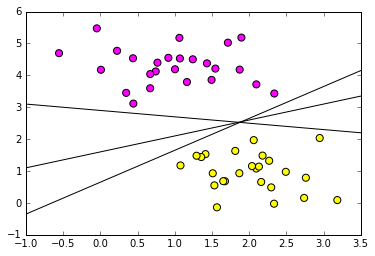

In [1]:
# Source: https://github.com/jakevdp/ESAC-stats-2014/blob/master/notebooks/04.1-Classification-SVMs.ipynb
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

xfit = np.linspace(-1, 3.5)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
    
plt.xlim(-1, 3.5)

## Support Vector Machines
This is where [Support Vector Machines (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) come in.  We are going to define a hyperplane (a plane in $N-1$ dimensions) that maximizes the distance of the closest point from each class.  This distance is the "margin".  It is the width of the "cylinder" that you can put between the closest points that just barely touches the points in each class.  The points that touch the margin are called **support vectors**.  Obvious, right?

Once again, we have an algortihm that seems purposely named to frighten people away.  Though I don't know that "Data-Supported Hyperplane" classification would be any better...

(-1, 3.5)

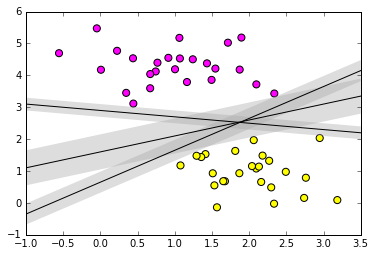

In [2]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

N.B.: For this next part, $\beta$ is not defined in $\S$ 9.5.1 or $\S$ 9.6.  In Equation 9.31 it appears to be the probability of success as defined by Equation 3.50 in $\S$ 3.3.3.  But later $\beta_0$ appears to be a multi-dimensional intercept and $\beta$ appears to be a multi-dimensional slope parameter, i.e., the parameters of the hyperplane.

To make life easier, we'll assume that the classes are separable by a straight line and that the decision boundary is at 0, with the two edges at $-1$ and $1$, and define $y \in \{-1,1\}$.

The maximum is then just when $\beta_0 + \beta^T x_i = 1$ etc

The hyperplane which maximizes the margin is given by finding

> \begin{equation}
\max_{\beta_0,\beta}(m) \;\;\;
  \mbox{subject to} \;\;\; \frac{1}{||\beta||} y_i ( \beta_0 + \beta^T x_i )
  \geq m \,\,\, \forall \, i.
\end{equation}

The constraints can be written as $y_i ( \beta_0 + \beta^T x_i ) \geq m ||\beta|| $. 

Thus the optimization problem is equivalent to minimizing
> \begin{equation}
\frac{1}{2} ||\beta|| \;\;\; \mbox{subject to} \;\;\; y_i
  ( \beta_0 + \beta^T x_i ) \geq 1 \,\,\, \forall \, i.
\end{equation}

This optimization  is a _quadratic programming_ problem (quadratic objective function with linear constraints)

For realistic data sets where the decision boundary is not obvious we relax the assumption that the classes are linearly separable.  This changes the minimization condition and puts bounds on the number of misclassifications (which we would obviously like to minimize).

To make sure that we get through all the remaining classification algorithms, we'll skip over the mathematical details.  You can read about them in Ivezic $\S$ 9.6 or in Karen Leighly's [classification lecture notes](http://seminar.ouml.org/lectures/classification/).

Treating Scikit-Learn's agorithm as a black box, let's fit a Support Vector Machine Classifier to these points.

The Scikit-Learn implementation of SVM classification is [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) which looks like:

In [3]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In order to better visualize what SVM is doing, let's create a convenience function that will plot the decision boundaries:

In [4]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 3)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 3)
    yy, xx = np.meshgrid(v, u)

    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = clf.decision_function(Xgrid.reshape(1,-1))
    return ax.contour(xx, yy, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

    #GTR: Not clear why we need the loops and can't just
    # make the Xgrid array like we normally do.

Now let's plot the decision boundary and the support vectors, which are stored in the `support_vectors_` attribute of the classifier.

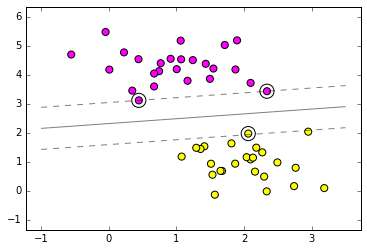

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(svm)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=200, facecolors='none')

Below is an example using the same data set from last time.

completeness [ 1.  1.  1.  1.]
contamination [ 0.90322581  0.8622449   0.86363636  0.8622449 ]


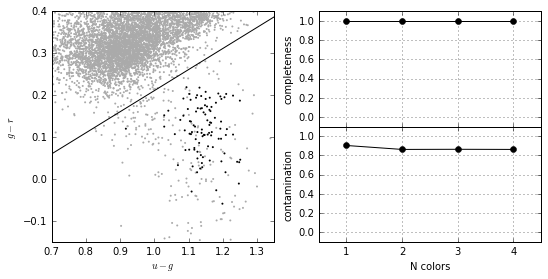

In [40]:
%matplotlib inline
# Ivezic, Figure 9.10
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
X = X[::5]
y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)
N_stars = np.sum(y == 0)
N_rrlyrae = N_tot - N_stars
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rrlyrae

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)

def compute_SVM(Ncolors):
    y_class = []
    y_pred = []

    for nc in Ncolors:
        # perform support vector classification
        svm = SVC(kernel='linear', class_weight='balanced')
        svm.fit(X_train[:, :nc], y_train)
        
        y_pred.append(svm.predict(X_test[:, :nc]))
        y_class.append(svm)

    return y_class, y_pred

y_class, y_pred = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(y_pred, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary
svm = y_class[1]
w = svm.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - svm.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

Some comments on these results:

- The median of a distribution is unaffected by large perturbations of outlying points, as long as those perturbations do not cross the boundary.
- In the same way, once the support vectors are determined, changes to the positions or numbers of points beyond the margin will not change the decision boundary.  For this reason, SVM can be a very powerful tool for discriminative classification.
- This is why there is a high completeness compared to the other methods: it does not matter that the background sources outnumber the RR Lyrae stars by a factor of $\sim$200 to 1. It simply determines the best boundary between the small RR Lyrae clump and the large background clump.
- This completeness, however, comes at the cost of a relatively large contamination level.

Note that:
- SVM is not scale invariant so it often worth rescaling the data to [0,1] or to whiten it to have a mean of 0 and variance 1 (remember to do this to the test data as well!)
- The data don't need to be separable (we can put a constraint in minimizing the number of "failures").

### Kernel Methods
If the contamination is driven by non-linear effects (which isn't the case here), it may be worth implementing a non-linear decision boundary.  As before, we do that by *kernelization*.  

Go to [Scikit-Learn SVM](http://scikit-learn.org/stable/modules/svm.html) and see if you can figure out how to implement SVC with the 'rbf' kernel  (As in Figure 9.11)

Let's take a quick look at an example where the data are not linearly separable and where kernelization really makes a difference.

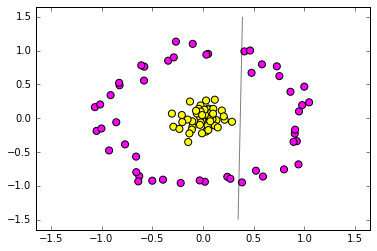

In [7]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)

But we can make a transform of the data to make it linearly separable, for example with a simple **radial basis function** as shown below.

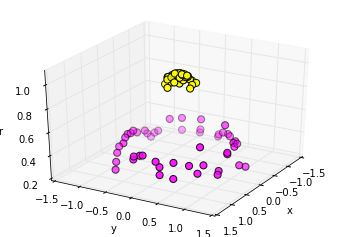

In [10]:
# Transform X using a radial basis function
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D()
# GTR: Or even fancier with 
#interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

Now we can trivially separate these populations as shown below!  
GTR: Something not quite right here, but you get the idea.

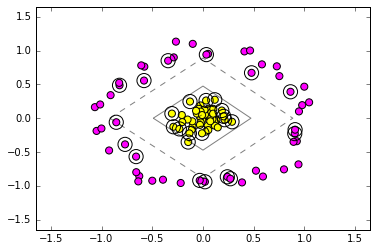

In [11]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none')

## Decision Trees

A [**decision tree**](https://en.wikipedia.org/wiki/Decision_tree) is similar to the process of classification that you might do by hand: define some criteria to separate the sample into 2 groups (not necessarily equal).  Then take those sub-groups and do it again.  Keep going until you reach a stopping point such as not having a minimum number of objects to split again.  In short, we have done a hierarchical application of decision boundaries.

The tree structure is as follows:
- top node contains the entire data set
- at each branch the data are subdivided into two child nodes 
- split is based on a predefined decision boundary (usually axis aligned)
- splitting repeats, recursively, until we reach a predefined stopping criteria 

Below is a simple example of a decision tree.

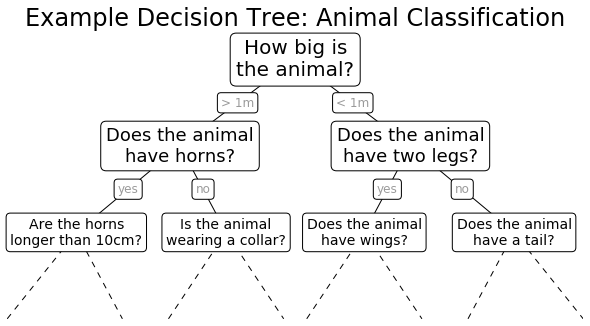

In [12]:
# Source: Jake VanderPlas, https://github.com/LocalGroupAstrostatistics2015/MachineLearning/blob/master/fig_code/figures.py
def plot_example_decision_tree():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
    ax.set_title('Example Decision Tree: Animal Classification', size=24)

    def text(ax, x, y, t, size=20, **kwargs):
        ax.text(x, y, t,
                ha='center', va='center', size=size,
                bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

    text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
    text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
    text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
    text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
    text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
    text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
    text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

    text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
    text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

    text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

    text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

    ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
    ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
    ax.axis([0, 1, 0, 1])

plot_example_decision_tree()

The "leaf (terminal) nodes" record the fraction of points that have one classification or the other

Application of the tree to classification is simple (a series of binary decisions). The  fraction of points from the training set classified as one class or the other (in the leaf node) defines the class associated with that leaf node.

The binary splitting makes this extremely efficient. Tthe trick is to ask the *right* questions.
So, decision trees are simple to interpret (just a set of questions).

Scikit-learn implements the [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as follows:

In [13]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)
dtree = DecisionTreeClassifier(max_depth=6)
dtree.fit(X,y)
y_pred = dtree.predict(X)

An example with our data set of RR Lyrae stars shows that it has moderately good completenees and contamination, but that, for this data set, it is not the optimal choice.

completeness [[ 0.00729927  0.3649635   0.29927007  0.62773723]
 [ 0.02189781  0.31386861  0.51824818  0.57664234]]
contamination [[ 0.66666667  0.375       0.31666667  0.31746032]
 [ 0.625       0.48809524  0.37719298  0.3875969 ]]


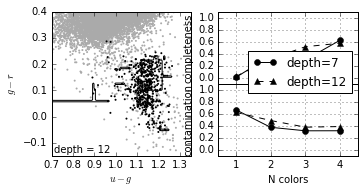

In [14]:
# Ivezic, Figure 9.13
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)
N_stars = np.sum(y == 0)
N_rrlyrae = N_tot - N_stars
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rrlyrae

#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

y_class = []
y_pred = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [7, 12]

for depth in depths:
    y_class.append([])
    y_pred.append([])
    for nc in Ncolors:
        dt = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
        dt.fit(X_train[:, :nc], y_train)
        y_pred[-1].append(dt.predict(X_test[:, :nc]))
        y_class[-1].append(dt)

completeness, contamination = completeness_contamination(y_pred, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary

dt = y_class[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))
#GTR Whoa!?  Why is this yy, xx and not xx, yy????
#Ah, because the plot reverses the usual python order
xystack = np.vstack([yy.ravel(),xx.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### Splitting Criteria

Now let's talk about the best ways to split the data.  This is actually a really hard problem, which you can read about more in Ivezic $\S$ 9.7.1.  

One way is to use the information content or entropy, $E(x)$, of the data

$$ E(x) = -\sum_i p_i(x) \ln (p_i(x)),$$

where $i$ is the class and $p_i(x)$ is the probability of that class
given the training data. 

Another commonly used "loss function" (especially for categorical classification) is the Gini coefficient:
$$ G = \sum_i^k p_i(1-p_i).$$

It essentially estimates the probability of incorrect classification by choosing both a point and (separately) a class randomly from the data.

Obviously in constructing a decision treee, if your choice of stopping criteria is too loose, further splitting just ends up adding noise.  So here is an example using cross-validation in order to optimize the depth of the tree (and to avoid overfitting).  

Note that here we aren't classifying the objects into discrete categories, rather we are classifying them into a continuous category.  That is, we are doing regression.  In this particular case, we are using the colors of galaxies in order to predict their redshifts (distances).

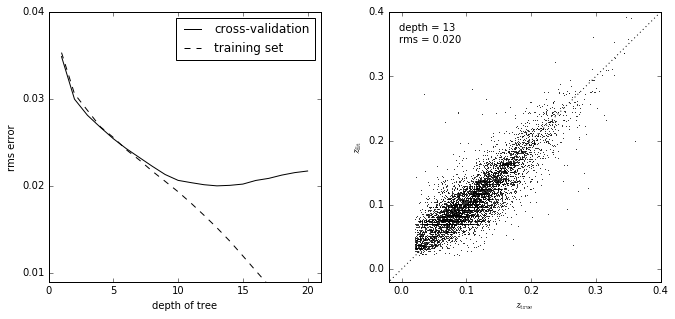

In [15]:
# Ivezic, Figure 9.14
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from astroML.datasets import fetch_sdss_specgals

#------------------------------------------------------------
# Fetch data and prepare it for the computation
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 separate points
mag_test = mag[1::100]
z_test = z[1::100]

#------------------------------------------------------------
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(mag_train, z_train)

    z_fit_train = clf.predict(mag_train)
    z_fit_test = clf.predict(mag_test)
    rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((z_fit_test - z_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        z_fit_best = z_fit_test

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

That's doing the Cross Validation by hand, let's try it automatically using data like the first example that we started with today.

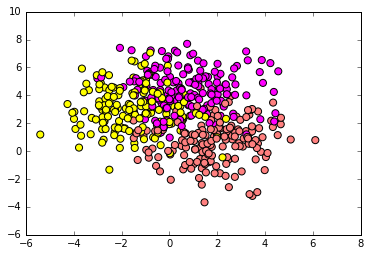

In [70]:
X, y = make_blobs(n_samples=500, centers=3,
                  random_state=0, cluster_std=1.50)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

In [71]:
from sklearn.grid_search import GridSearchCV

clf = DecisionTreeClassifier()
drange = np.arange(1,21)

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5)
grid.fit(X, y)

print("best parameter choice:", grid.best_params_)

('best parameter choice:', {'max_depth': 7})


Now plot the decision boundary

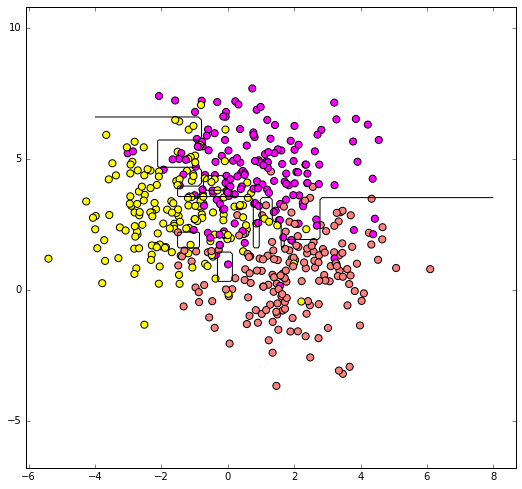

In [75]:
dt = DecisionTreeClassifier(max_depth=7)# Complete
dt.fit(X, y)

xlim = (-4, 8)
        
ylim = (-6, 10)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T
Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)
#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.spring, zorder=2)

ax.contour(xx, yy, Z, [0.5], colors='k')

## Ensemble Learning

You may have noticed that each of the classification methods that we have described so far has its strengths and weaknesses.  You might wonder if we could gain something by some sort of averaging of weighted "voting".  Such a process is what we call *ensemble learning*.  We'll discuss two such processes: [**bagging**](https://en.wikipedia.org/wiki/Bootstrap_aggregating) and [**random forests**](https://en.wikipedia.org/wiki/Random_forest).

### Bagging

Bagging (short for *bootstrap aggregation*--a name, unlike SVM, which actually makes some sense) can significantly improve the performance of decision trees.  In short, bagging averages the predictive results of a series of bootstrap samples.

Bootstrap is one of the many important things that we skipped over earlier in the course.  It is just another way of dividing the data set for testing.  

Instead of splitting the sample into training and test sets that do not overlap, bootstrap says to draw from the observed data set with replacement.  So we select indices $j$ from the range $i=1,\ldots,N$ and this is our new sample.  Some indices, $i$, will be repeated and we do this $B$ times.

For a sample of $N$ points in a training set, bagging generates $B$ equally sized bootstrap samples from which to estimate the function $f_i(x)$. The final estimator for $\hat{y}$, defined by bagging, is then
$$\hat{y} = f(x) = \frac{1}{B} \sum_i^B f_i(x).$$

### Random Forests
Random forests extend bagging by generating decision trees from the bootstrap samples.  A interesting aspect of random forests is that the features on which to generate the tree are selected at random from the full set of features in the data (the number of features selected per split level is typically the square root of the total number of attributes, $\sqrt{D}$).  The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees.  So, you can literally give it the kitchen sink (including attributes that you might not otherwise think would be useful for classification).

Random forests help to overcome some of the limitations of decision trees.

As before, cross-validation can be used to determine the optimal depth.  Generally the number of trees, $n$, that are chosen is the number at which the cross-validation error plateaus.

Below we give the same example as above for estimation of galaxy redshifts, where Scikit-Learn's [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) call looks as follows:

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)
ranfor = RandomForestClassifier(10)
ranfor.fit(X,y)
y_pred = ranfor.predict(X)

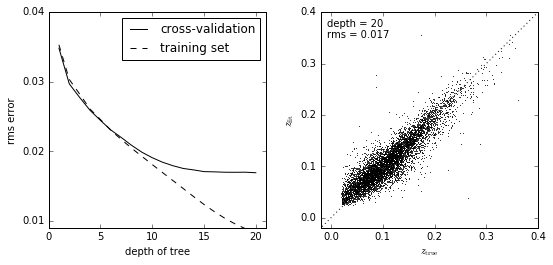

In [4]:
# Ivezic, Figure 9.15
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

## Boosting

Boosting is an ensemble approach motivated by the idea that combining many weak classifiers can result in an improved classification. Boosting creates models that attempt to correct the errors of the ensemble so far. At the heart of boosting is the idea that we reweight the data based on how incorrectly the data were classified in the previous iteration.

We run the classification multiple times and each time reweight the data based on the previous performance of the classifier. At the end of this procedure we allow the classifiers to vote on the final classification. The most popular form of boosting is that of adaptive boosting.  In this case we take a weak classifier, $h(x)$, and create a strong classifier, $f(x)$, as
$$ f(x) = \sum_m^B\theta_m h_m(x),$$
where $m$ is the number of iterations and $\theta_m$ is the weight of the classifier in each iteration.  

If we chose $\theta_m=1/B$, then we'd essentially have bagging.  For boosting the idea is to increase the weight of the misclassified data in each step.

A fundamental limitation of the boosted decision tree is the computation time for large data sets (they rely on a chain of classifiers which are each dependent on the last), whereas random forests can be easily parallelized.

The example given below is actually Scikit-Learn's [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) where we approximate the steepest descent criterion after each simple evaluation.

In [5]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)
gradboost = GradientBoostingClassifier()
gradboost.fit(X,y)
y_pred = gradboost.predict(X)

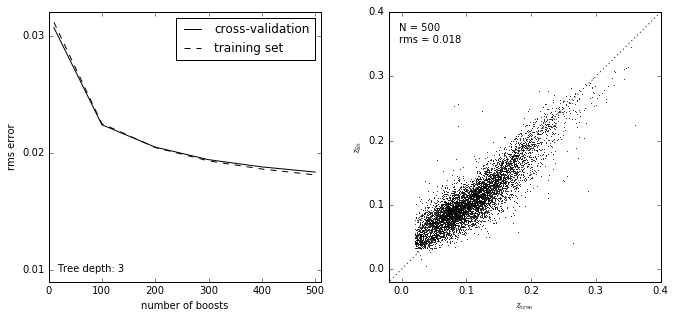

In [6]:
# Ivezic, Figure 9.16
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from astroML.datasets import fetch_sdss_specgals

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        try:
            # older versions of scikit-learn
            clf = GradientBoostingRegressor(n_estimators=Nb, learn_rate=0.1,
                                            max_depth=3, max_features='sqrt', random_state=0)
        except TypeError:
            clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                            max_depth=3, max_features='sqrt', random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

## Alright, alright but what the @#%! should I use?

A convenient cop-out: no single model can be known in advance to be the best classifier!

In general the level of accuracy increases for parametric models as:
- <b>naive Bayes</b>, 
- linear discriminant analysis (LDA),
- logistic regression, 
- linear support vector machines, 
- quadratic discriminant analysis (QDA),
- linear ensembles of linear models. 

For non-parametric models accuracy increases as:
- decision trees
- $K$-nearest-neighbor, 
- neural networks
- kernel discriminant analysis,
- <b> kernelized support vector machines</b>
- <b> random forests</b>
- boosting

See also Ivezic, Table 9.1.

Naive Bayes and its variants are by far the easiest to compute. Linear support vector machines are more expensive, though several fast algorithms exist. Random forests can be easily parallelized. 

We saw before that Scikit-learn has tools for computing ROC curves, which is implemented as follows.  

In [7]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
X = np.random.random((100,2))
y = (X[:,0] + X[:,1] > 1).astype(int)

gnb = GaussianNB().fit(X,y)
y_prob = gnb.predict_proba(X)

# Compute precision/recall curve
pr, re, thresh = metrics.precision_recall_curve(y, y_prob[:,0])

# Compute ROC curve
tpr, fpr, thresh = metrics.roc_curve(y, y_prob[:,0])

Let's remember what they had to say:

![Ivezic, Figure 9.17](http://www.astroml.org/_images/fig_ROC_curve_1.png)

Here's an example with a different data set.  Here we are trying to distinguish quasars (in black) from stars (in grey).  Add a precision recall plot.

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


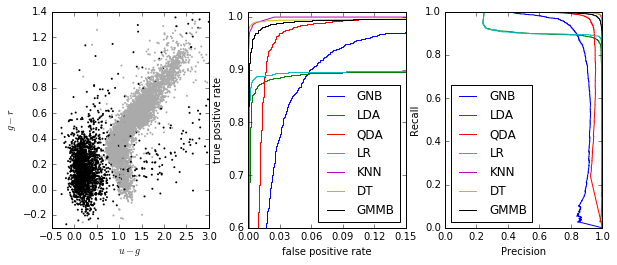

In [19]:
# Ivezic, 9.18
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.utils import split_samples

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve # Complete
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes
#from sklearn.mixture import GaussianMixture

#------------------------------------------------------------
# Fetch data and split into training and test samples
from astroML.datasets import fetch_dr7_quasar
from astroML.datasets import fetch_sdss_sspp

quasars = fetch_dr7_quasar()
stars = fetch_sdss_sspp()

# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

# stack colors into matrix X
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)


#------------------------------------------------------------
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print classifier.__name__
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (LDA, {}),
                               (QDA, {}),
                               (LogisticRegression,
                                dict(class_weight=LRclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')),
                               (GMMBayes, dict(n_components=3, tol=1E-5,
                                               covariance_type='full')))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(9, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(131)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(132)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    ax2.plot(fpr, tpr, label=labels[name])

ax2.legend(loc=4)
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

#Third plot, precision-recall curve
ax3 = fig.add_subplot(133)
for name, y_prob in zip(names, probs):
    prec, rec, dummy = precision_recall_curve(y_test, y_prob)
    prec = np.concatenate([[0], prec])
    rec = np.concatenate([[1], rec])
    ax3.plot(prec, rec, label=labels[name])
ax3.set_xlabel('Precision')
ax3.set_ylabel('Recall')
ax3.legend(loc=3)

plt.show()

Curiously GMMBayes went from being one of the best to one of the worst after I changed from using the deprecated GMMBayes to GaussianMixture.  So, it is likely that the current input parameters are not optimal for that.